# **Pairs Trading**

In [39]:
!pip install yfinance

In [40]:
!pip install pandas_ta

In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm

## **Importing Stock Price dataset**



In [42]:
start_date = "2018-12-31"
end_date = "2022-12-31"

stocks = ["INDUSINDBK.NS", "HDFCBANK.NS", "PNB.NS", "ICICIBANK.NS", "BANKBARODA.NS", "SBIN.NS", "IDFCFIRSTB.NS", "KOTAKBANK.NS", "FEDERALBNK.NS", "AXISBANK.NS", "AUBANK.NS"]

In [43]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%%**********************]  11 of 11 completed


Ticker,AUBANK.NS,AXISBANK.NS,BANKBARODA.NS,FEDERALBNK.NS,HDFCBANK.NS,ICICIBANK.NS,IDFCFIRSTB.NS,INDUSINDBK.NS,KOTAKBANK.NS,PNB.NS,SBIN.NS
Date,,,,,,,,,,,
2018-12-31,309.536652,616.445190,108.947632,89.028755,1009.855225,346.449646,43.349998,1536.329712,1252.040283,74.565125,278.514221
2019-01-01,309.462097,623.803955,113.074440,88.790077,1022.420776,349.912659,43.349998,1532.775146,1246.011719,76.188187,281.996826
2019-01-02,308.616180,616.594360,109.452019,90.508591,1013.091858,350.730377,42.700001,1514.523438,1236.196777,74.326447,276.631714
2019-01-03,309.163483,604.561890,109.406166,87.835335,1005.143188,349.431702,43.049999,1498.672852,1230.865723,74.326447,273.996246
2019-01-04,310.407440,616.146851,111.607117,90.508591,1007.832458,351.307556,45.150002,1487.241333,1243.520630,77.620300,280.161377


## **Identifying stock pairs**

### **Cointegration**



In [44]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs

<Axes: >

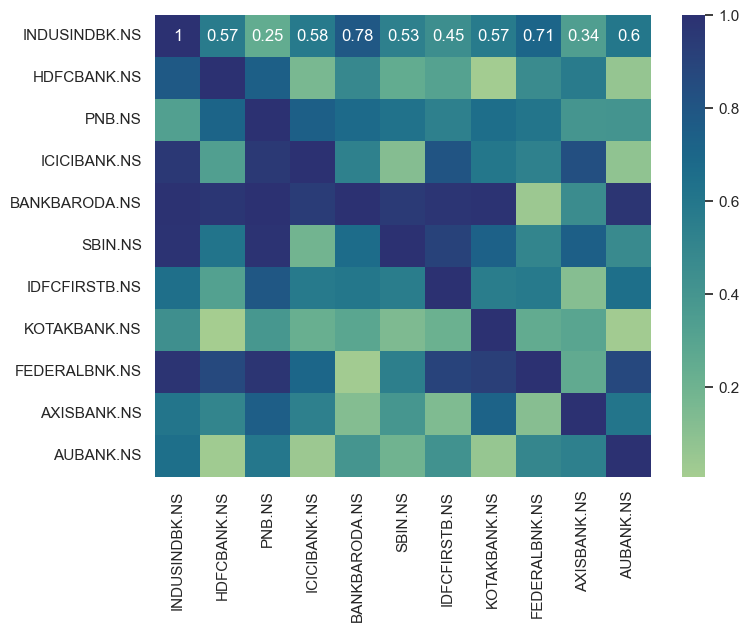

In [45]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

In [46]:
min(stock_pairs)

(0.006010519500017569, ('KOTAKBANK.NS', 'HDFCBANK.NS'))

**Selected pair: HDFC Bank & Kotak Bank**

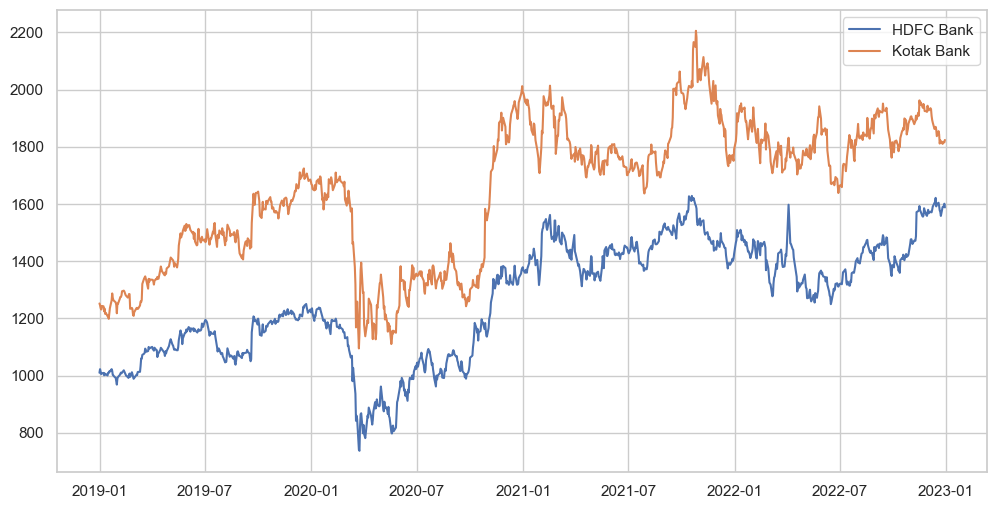

In [47]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data['HDFCBANK.NS'], label = 'HDFC Bank')
plt.plot(stock_data['KOTAKBANK.NS'], label = 'Kotak Bank')
plt.legend()
plt.show()

### **Testing Data**

In [48]:
stock_pair = ['KOTAKBANK.NS', 'HDFCBANK.NS']
asset_pairs =  yf.download(stock_pair, start="2022-12-02" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

[*********************100%%**********************]  2 of 2 completed


## **Z-Score**



In [49]:
def zscore(S1, S2):
    lookback = 20
    scores = []
    for i in range(lookback, len(S1)):
      windowX = S1[i-lookback:i]
      windowY = S2[i-lookback:i]
      windowX = sm.add_constant(windowX)
      results = sm.OLS(windowY, windowX).fit()
      windowX = windowX[stock_pair[0]]
      b = results.params[stock_pair[0]]
      a = results.params['const']
      spread = windowY - b * windowX - a
      scores.append((spread[-1]-spread.mean())/spread.std())
    return pd.Series(scores, index = S1.index[lookback:])


/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/3190186780.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores.append((spread[-1]-spread.mean())/spread.std())
/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/3190186780.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores.append((spread[-1]-spread.mean())/spread.std())
/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/3190186780.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

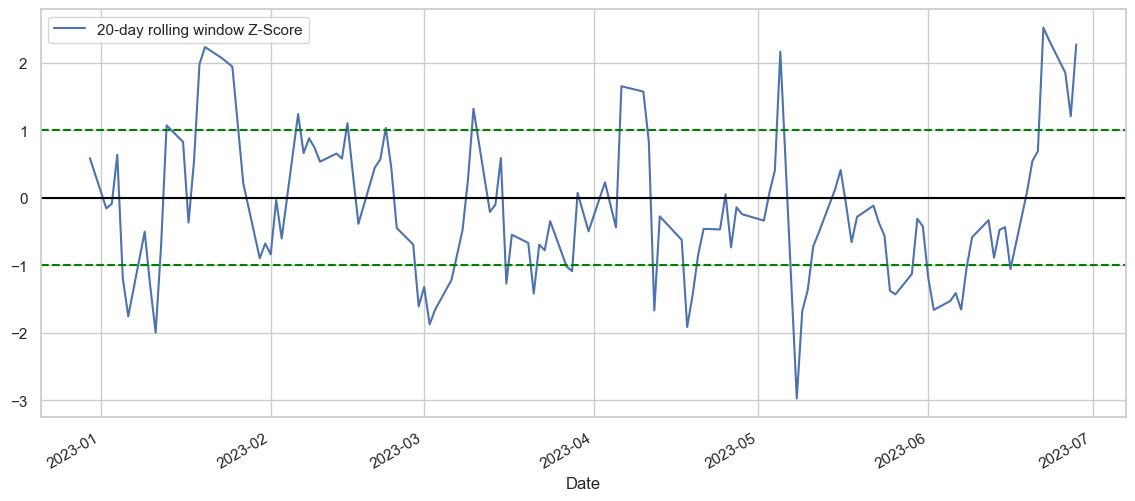

In [50]:
zscores = zscore(S1, S2)
zscores.plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

## **Trading Strategy**



In [51]:
def generate_trade_signals(S1, S2, zscores):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['zscore'] = zscores

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

In [52]:
trade_signals = generate_trade_signals(S1, S2, zscores)
trade_signals.dropna(inplace = True)
trade_signals

,price1,price2,zscore,signal1,position1,signal2,position2
Date,,,,,,,
2023-01-02,1821.552124,1588.541748,-0.158451,0,0.0,0,0.0
2023-01-03,1829.337158,1598.929077,-0.088911,0,0.0,0,0.0
2023-01-04,1817.260254,1570.351685,0.634370,0,0.0,0,0.0
2023-01-05,1816.811157,1560.256714,-1.188558,-1,-1.0,1,1.0
2023-01-06,1783.375488,1555.087524,-1.754424,-1,0.0,1,0.0
...,...,...,...,...,...,...,...
2023-06-22,1832.580811,1621.458252,2.517657,1,1.0,-1,-1.0
2023-06-23,1825.045410,1621.359619,2.337920,1,0.0,-1,0.0
2023-06-26,1819.455933,1613.516724,1.849825,1,0.0,-1,0.0


### **Visualising the positions**

**1) Trades on the pair**

In [53]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

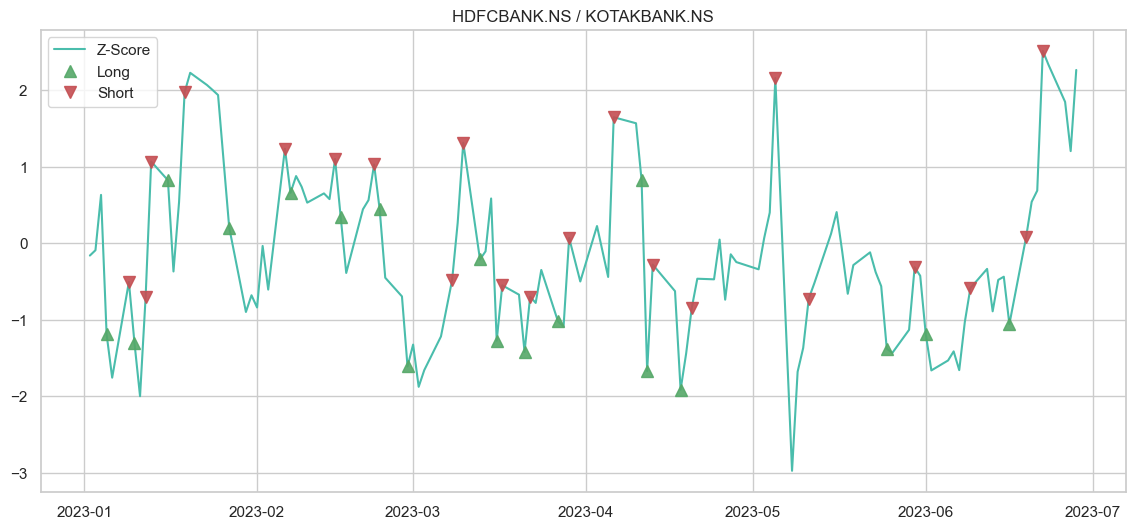

In [54]:
plot_pair_trades(trade_signals)

*   **Long position => buy HDFC Bank and sell Kotak Bank**
*   **Short position => sell HDFC Bank and buy Kotak Bank**

**2) Trades on Kotak Bank**

In [55]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

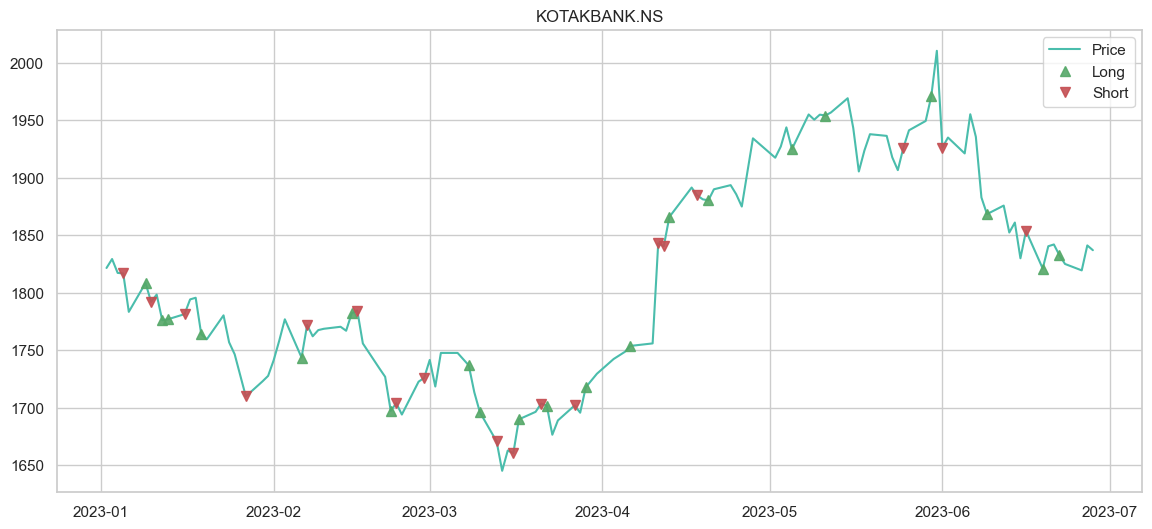

In [56]:
plot_trades_1(trade_signals)

**3) Trades on HDFC Bank**

In [57]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

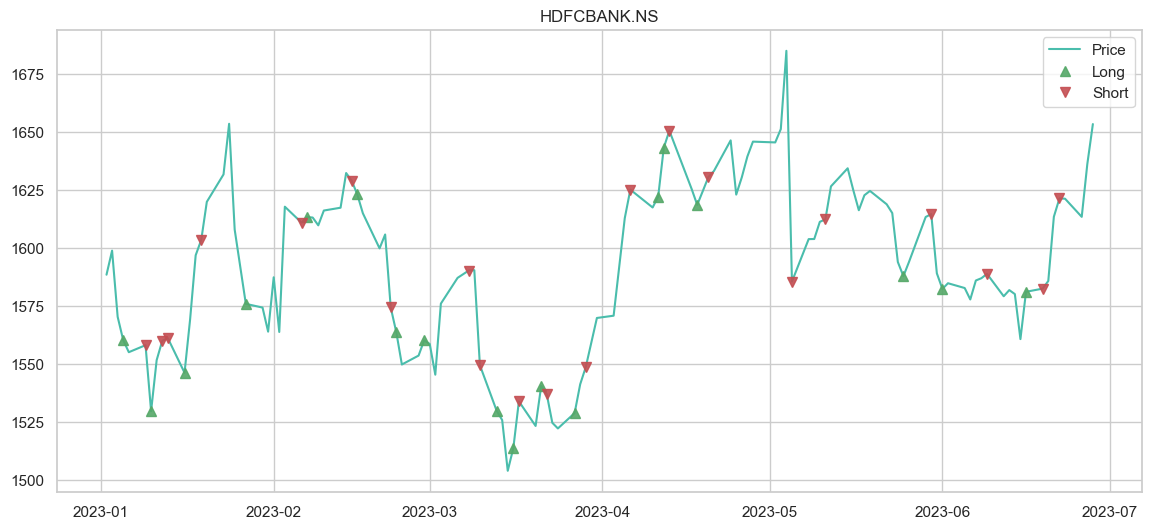

In [58]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [59]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [60]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/791995448.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares1 = initial_capital// (signals['price1'][0])
/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/791995448.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares2 = initial_capital// (signals['price2'][0])


,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2023-01-03,0.000000,50000.000000,50000.000000,0.000000,0.000000,50000.000000,50000.000000,0.000000,100000.000000
2023-01-04,0.000000,50000.000000,50000.000000,0.000000,0.000000,50000.000000,50000.000000,0.000000,100000.000000
2023-01-05,-49053.901245,99053.901245,50000.000000,0.000000,48367.958130,1632.041870,50000.000000,0.000000,100000.000000
2023-01-06,-48151.138184,99053.901245,50902.763062,0.018055,48207.713257,1632.041870,49839.755127,-0.003205,100742.518188
2023-01-09,0.000000,50226.362305,50226.362305,-0.013288,0.000000,49933.481689,49933.481689,0.001881,100159.843994


In [61]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

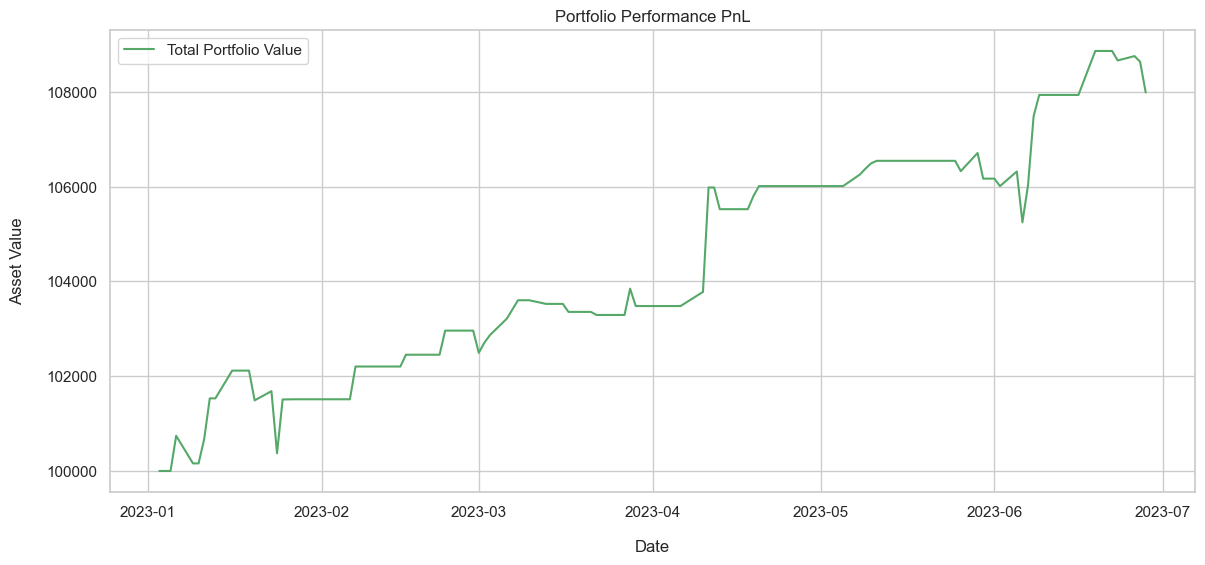

In [62]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [63]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [64]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  120
CAGR = 17.515%


[*********************100%%**********************]  1 of 1 completed
/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/1360885660.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares = 100000/index[0]


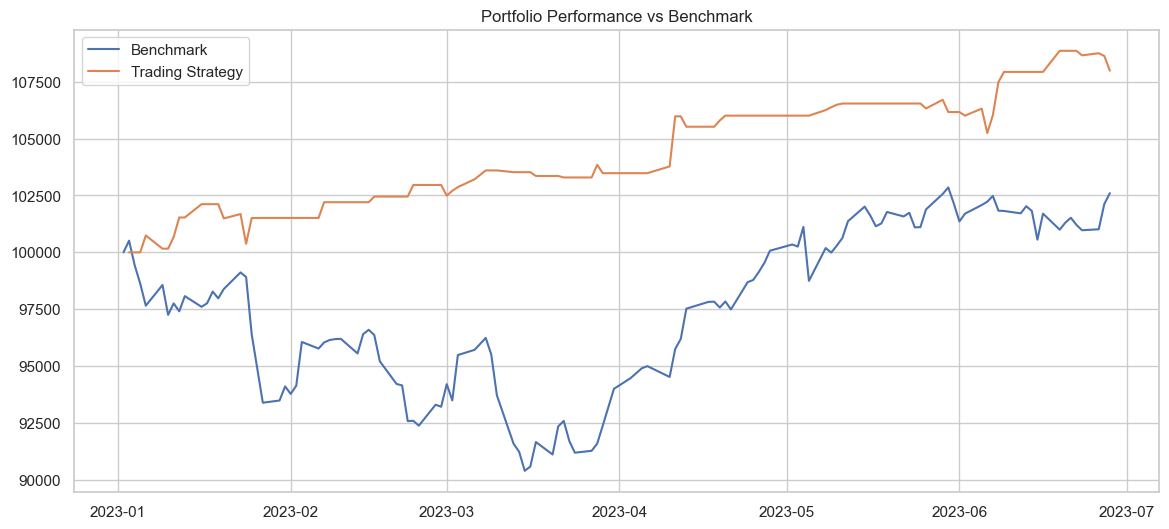

In [65]:
index = yf.download('^NSEBANK', start = '2023-01-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [66]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of NIFTY Bank:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of NIFTY Bank: 5.498 %
CAGR of trading strategy: 17.515 %


/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/2059723931.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
/var/folders/qc/z_nrrkgd0kz_2fgk7xhr3b5w0000gn/T/ipykernel_10504/2059723931.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
